In [1]:
# plot comparison elastic-net VS PriLer
library(ggplot2)
library(ggrepel)
library(gridExtra)
library(latex2exp)
library(data.table)
library(jaccard)
library(ggpubr)

setwd('/psycl/g/mpsziller/lucia/')

tissues_model <- read.csv('PriLer_PROJECT_GTEx/INPUT_DATA/final_model_gtex.csv', h=F, stringsAsFactors = F)
outFold <- 'castom_cad_scz/jupyter_notebook/PriLer/'

colnames(tissues_model) <- c('tissue', 'type')
tissues_model$folder_train <- sapply(tissues_model$tissue, function(x) sprintf('PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2/%s/200kb/noGWAS/', x))
tissues_model$folder_train[tissues_model$type == 'CAD'] <- sapply(tissues_model$tissue[tissues_model$type == 'CAD'] ,
                                                                  function(x) sprintf('PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2/%s/200kb/CAD_GWAS_bin5e-2/', x))
tissues_model$folder_train[tissues_model$type == 'PGC'] <- sapply(tissues_model$tissue[tissues_model$type == 'PGC'], 
                                                                  function(x) sprintf('PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2/%s/200kb/PGC_GWAS_bin1e-2/', x))

type <- c('All')
res_CMC <- paste0('PriLer_PROJECT_CMC/OUTPUT_CMC_SCRIPTS_v2/train_', type, '/200kb/')

df_prior <- list()
df_noprior <- list()
df_both <- list()
df_regSNPs <- list()
df_nrel <- list()

df_sampleSize <- read.table('PriLer_PROJECT_CMC/OUTPUT_CMC_SCRIPTS_v2/nSamples_nRelGenes.txt', h=T, stringsAsFactors=F)
df_sampleSize <- df_sampleSize[df_sampleSize$type %in% 'All',]
df_sampleSize$type <- 'DLPC_CMC'
df_sampleSize <- rbind(df_sampleSize, read.table('PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2/nSamples_nRelGenes.txt', h=T, stringsAsFactors=F))

color_tissues <- fread('castom_cad_scz/jupyter_notebook/color_tissues.txt', h=T, stringsAsFactors=F, data.table = F)


In [5]:
# load CMC (train_All) res 
df_prior[[1]] <- read.delim(sprintf('%s/resPrior_regEval_allchr.txt', res_CMC), h=T, stringsAsFactors = F, sep = '\t')
df_prior[[1]]$tissue <- 'DLPC_CMC'
df_noprior[[1]] <- read.delim(sprintf('%s/resNoPrior_regEval_allchr.txt', res_CMC), h=T, stringsAsFactors = F, sep = '\t')
df_noprior[[1]]$tissue <- 'DLPC_CMC'

df_nrel[[1]] <- data.frame(tissue = 'DLPC_CMC', n_samples = df_sampleSize$n_samples[df_sampleSize$type == 'DLPC_CMC'], prior = length(which(df_prior[[1]]$test_dev_geno>0 & df_prior[[1]]$dev_geno>0.01)),
                           noprior = length(which(df_noprior[[1]]$test_dev_geno>0 & df_noprior[[1]]$dev_geno>0.01)), 
                           total_genes = sum(!is.na(df_prior[[1]]$dev_geno)))
df_both[[1]] <- data.frame(geneID = df_prior[[1]]$ensembl_gene_id, 
                           dev_geno_prior = df_prior[[1]]$dev_geno, dev_geno_noprior = df_noprior[[1]]$dev_geno,
                           test_dev_geno_prior = df_prior[[1]]$test_dev_geno, test_dev_geno_noprior = df_noprior[[1]]$test_dev_geno,
                           tissue = df_prior[[1]]$tissue, stringsAsFactors = F)
# only reliable genes for prior
df_both[[1]] <- df_both[[1]][df_both[[1]]$test_dev_geno_prior>0 & df_both[[1]]$dev_geno_prior>0.01, ]

df_both[[1]]$increase <- (df_both[[1]]$dev_geno_prior - df_both[[1]]$dev_geno_noprior)/df_both[[1]]$dev_geno_noprior

tmp <- read.delim(sprintf('%s/nVariants_prior_compare.txt', res_CMC), h=T, stringsAsFactors = F, sep = '\t')
df_regSNPs[[1]] <- data.frame(tissue = 'DLPC_CMC', nregSNPS_prior = sum(tmp$len[tmp$type == 'el-net learned prior']), 
                              nregSNPS_noprior = sum(tmp$len[tmp$type == 'el-net']),stringsAsFactors = F)
df_regSNPs[[1]]$frac_prior <- sum(tmp$len[tmp$type == 'el-net learned prior' & tmp$type_snp %in% c('with prior (common)', 'with prior (unique)')])/df_regSNPs[[1]]$nregSNPS_prior
df_regSNPs[[1]]$frac_noprior <- sum(tmp$len[tmp$type == 'el-net' & tmp$type_snp %in% c('with prior (common)', 'with prior (unique)')])/df_regSNPs[[1]]$nregSNPS_noprior

# load GTEx res 
for(i in 1:nrow(tissues_model)){
  
  print(i)
  df_prior[[i+1]] <- read.delim(sprintf('%s/resPrior_regEval_allchr.txt',  tissues_model$folder_train[i]), h=T, stringsAsFactors = F, sep = '\t')
  df_prior[[i+1]]$tissue <- tissues_model$tissue[i]
  df_noprior[[i+1]] <- read.delim(sprintf('%s/resNoPrior_regEval_allchr.txt',  tissues_model$folder_train[i]), h=T, stringsAsFactors = F, sep = '\t')
  df_noprior[[i+1]]$tissue <- tissues_model$tissue[i]
  
  df_nrel[[i+1]] <- data.frame(tissue = tissues_model$tissue[i], n_samples = df_sampleSize$n_samples[df_sampleSize$type == tissues_model$tissue[i]], 
                               prior = length(which(df_prior[[i+1]]$test_dev_geno>0 & df_prior[[i+1]]$dev_geno>0.01)),
                               noprior = length(which(df_noprior[[i+1]]$test_dev_geno>0 & df_noprior[[i+1]]$dev_geno>0.01)), 
                               total_genes = sum(!is.na(df_prior[[i+1]]$dev_geno)))
  df_both[[i+1]] <- data.frame(geneID = df_prior[[i+1]]$ensembl_gene_id, 
                               dev_geno_prior = df_prior[[i+1]]$dev_geno, dev_geno_noprior = df_noprior[[i+1]]$dev_geno,
                               test_dev_geno_prior = df_prior[[i+1]]$test_dev_geno, test_dev_geno_noprior = df_noprior[[i+1]]$test_dev_geno,
                               tissue = df_prior[[i+1]]$tissue, stringsAsFactors = F)
  # only reliable genes for prior
  df_both[[i+1]] <- df_both[[i+1]][df_both[[i+1]]$test_dev_geno_prior>0 & df_both[[i+1]]$dev_geno_prior>0.01, ]
  df_both[[i+1]]$increase <- (df_both[[i+1]]$dev_geno_prior - df_both[[i+1]]$dev_geno_noprior)/df_both[[i+1]]$dev_geno_noprior
  
  tmp <- read.delim(sprintf('%s/nVariants_prior_compare.txt', tissues_model$folder_train[i]), h=T, stringsAsFactors = F, sep = '\t')
  df_regSNPs[[i+1]] <- data.frame(tissue = tissues_model$tissue[i], nregSNPS_prior = sum(tmp$len[tmp$type == 'el-net learned prior']), 
                                  nregSNPS_noprior = sum(tmp$len[tmp$type == 'el-net']),stringsAsFactors = F)
  df_regSNPs[[i+1]]$frac_prior <- sum(tmp$len[tmp$type == 'el-net learned prior' & tmp$type_snp %in% c('with prior (common)', 'with prior (unique)')])/df_regSNPs[[i+1]]$nregSNPS_prior
  df_regSNPs[[i+1]]$frac_noprior <- sum(tmp$len[tmp$type == 'el-net' & tmp$type_snp %in% c('with prior (common)', 'with prior (unique)')])/df_regSNPs[[i+1]]$nregSNPS_noprior
  
}

df_nrel <- do.call(rbind, df_nrel)
df_snps <- do.call(rbind, df_regSNPs)


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33


In [6]:
n_relGenes <- data.frame(tissues = c('DLPC_CMC', tissues_model$tissue), 
                         col = color_tissues$color[match(c('DLPC_CMC', tissues_model$tissue), color_tissues$tissues)], 
                         stringsAsFactors = F)

prior_names <- read.csv('PriLer_PROJECT_GTEx/prior_association_TRAIN.csv', h=F, stringsAsFactors = F)
rownames(prior_names) <- prior_names$V1
prior_names <- prior_names[,-1]
prior_names <- prior_names[match(n_relGenes$tissues,rownames(prior_names)),]
nprior <- apply(prior_names, 1, function(x) sum(x != ''))
df_n_prior <- data.frame(tissue = n_relGenes$tissues, n_prior = nprior)
rownames(df_n_prior) <- NULL
prior_names_new <- apply(prior_names, 1, function(x) paste0(x[x != ''], collapse = '-and-')) 
summary_table <- data.frame(tissue = n_relGenes$tissues, 
                            n_training_samples = df_nrel$n_samples,
                            n_genes_total = df_nrel$total_genes,
                            prior_features = prior_names_new, n_prior_feat = df_n_prior$n_prior, 
                            n_genes_reliable = df_nrel$prior)
                

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


[1] "correlation n. samples and n.reliable genes (PriLer): 0.853762295755554"

[1] "correlation n. samples and n.reliable genes (enet): 0.851593001744045"

[1] "Total n.new genes in PriLer compared to enet: 2922"

[1] "Mean n.new genes in PriLer compared to enet: 85.9411764705882"

[1] "SD n.new genes in PriLer compared to enet: 47.3861897644467"

[1] "correlation n.new genes in PriLer and n. of prior: 0.163217247385478"

[1] "correlation n.new genes in PriLer and n. of samples: 0.197966769760598"

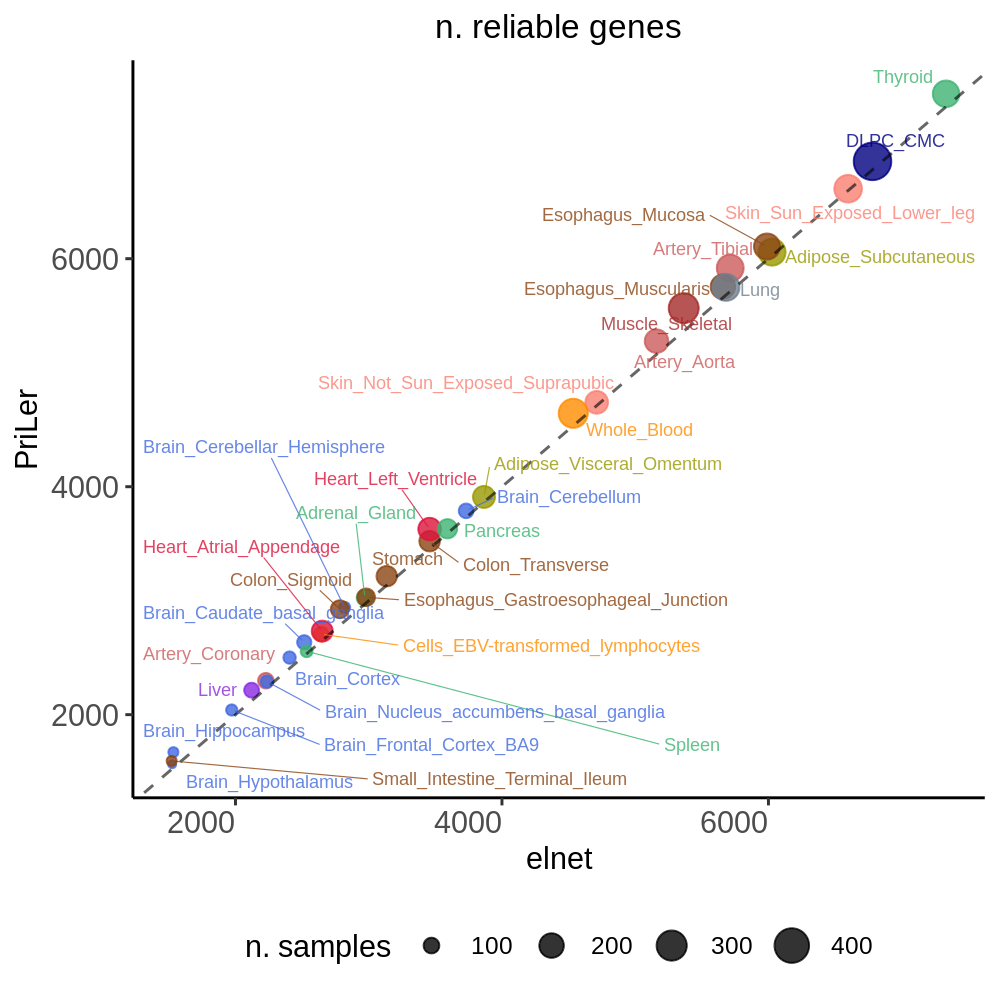

In [7]:
##############################
### plot n. reliable genes ###
##############################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

df_nrel$tissue <- factor(df_nrel$tissue, levels = summary_table$tissue)

pl_nrel <- ggplot(df_nrel, aes(x = noprior, y = prior, color = tissue, size = n_samples)) + 
  geom_point(alpha = 0.8)+
  # xlim(min_v, max_v)+ ylim(min_v, max_v)+
  geom_abline(slope = 1, intercept = 0, linetype = 2, alpha = 0.6)+ggtitle('n. reliable genes')+
  xlab('elnet')+ ylab('PriLer')+ theme_classic()+
  geom_text_repel(max.overlaps = Inf, label = df_nrel$tissue, size = 2.3, alpha = 0.8, segment.size = 0.2, force = 7)+
  theme(plot.title = element_text(hjust = 0.5, size = 12), text = element_text(size = 11),
        axis.text.x=element_text(size = 11, angle = 0, hjust = 1),
        axis.text.y=element_text(size = 11), legend.position = 'bottom')+
  guides(color = FALSE, size = guide_legend(title="n. samples"))+
  scale_color_manual(values = n_relGenes$col)

df_nrel$col <- color_tissues$color

ggsave(filename = sprintf('%snRelGenes_PriLerVSelnet_AllTissues.png', outFold), plot = pl_nrel, width = 5, height = 5, dpi = 500)
ggsave(filename = sprintf('%snRelGenes_PriLerVSelnet_AllTissues.pdf', outFold), plot = pl_nrel, width = 5, height = 5, dpi = 500)

df_nrel$diff_ngenes <- df_nrel$prior -  df_nrel$noprior

paste("correlation n. samples and n.reliable genes (PriLer):", cor(df_nrel$n_samples, df_nrel$prior)) # 0.8537
paste("correlation n. samples and n.reliable genes (enet):",cor(df_nrel$n_samples, df_nrel$noprior)) # 0.8516
paste("Total n.new genes in PriLer compared to enet:", sum(df_nrel$diff_ngenes)) # 2922
paste("Mean n.new genes in PriLer compared to enet:", mean(df_nrel$diff_ngenes)) # 85.94118
paste("SD n.new genes in PriLer compared to enet:", sd(df_nrel$diff_ngenes)) # 47.38619
paste("correlation n.new genes in PriLer and n. of prior:", cor(df_nrel$diff_ngenes, df_n_prior$n_prior)) # 0.1632172
paste("correlation n.new genes in PriLer and n. of samples:", cor(df_nrel$diff_ngenes, df_nrel$n_samples)) # 0.1979668 

# print
pl_nrel


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


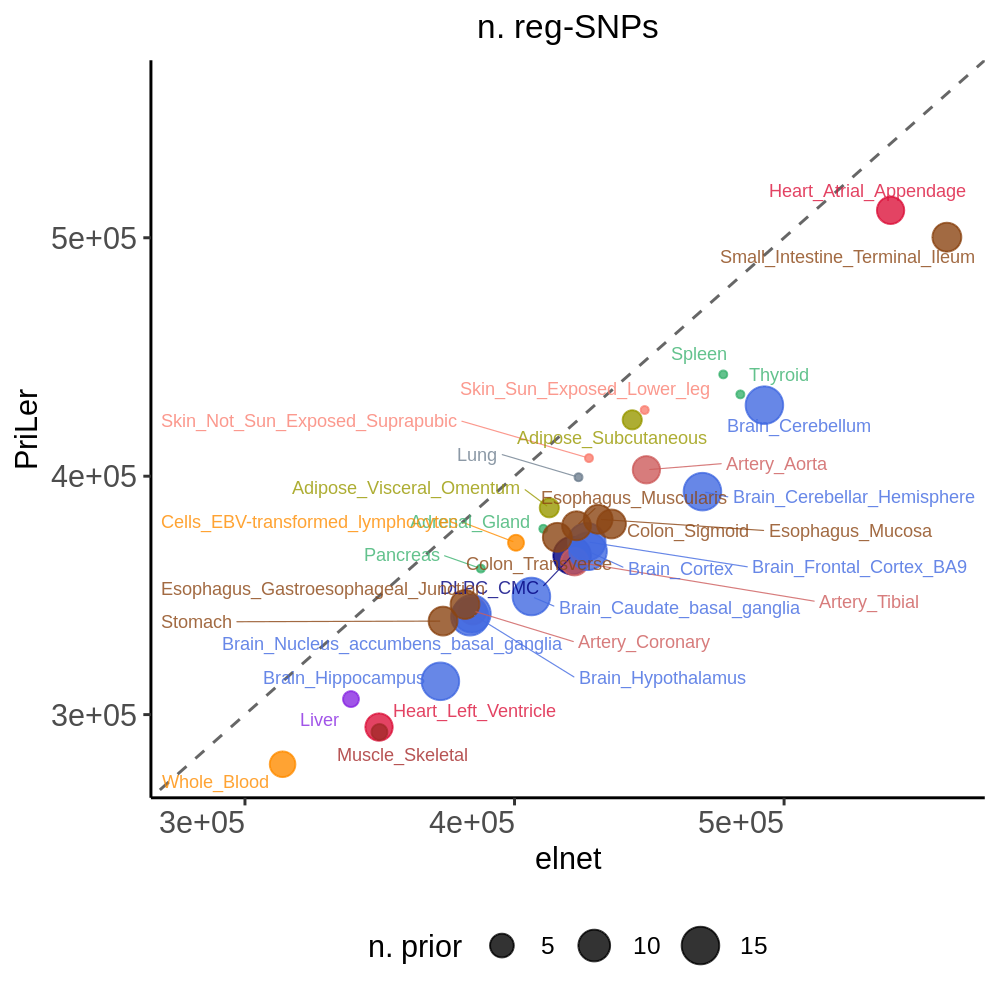

[1] "correlation n. priors and difference n.reg-SNPs (PriLer - enet): -0.685447006653819"

[1] "correlation n. priors and difference fraction prior reg-SNPs (PriLer - enet): 0.256177294503579"

[1] "mean difference reg-SNPs (PriLer - enet): -43013.7058823529"

[1] "SD difference reg-SNPs (PriLer - enet): 14530.5142133654"

[1] "sum difference reg-SNPs (PriLer - enet): -1462466"

[1] "mean difference fraction of reg-SNPs (PriLer - enet): 0.113857515291441"

[1] "mean difference fraction of reg-SNPs (PriLer - enet): 0.0332476524536298"

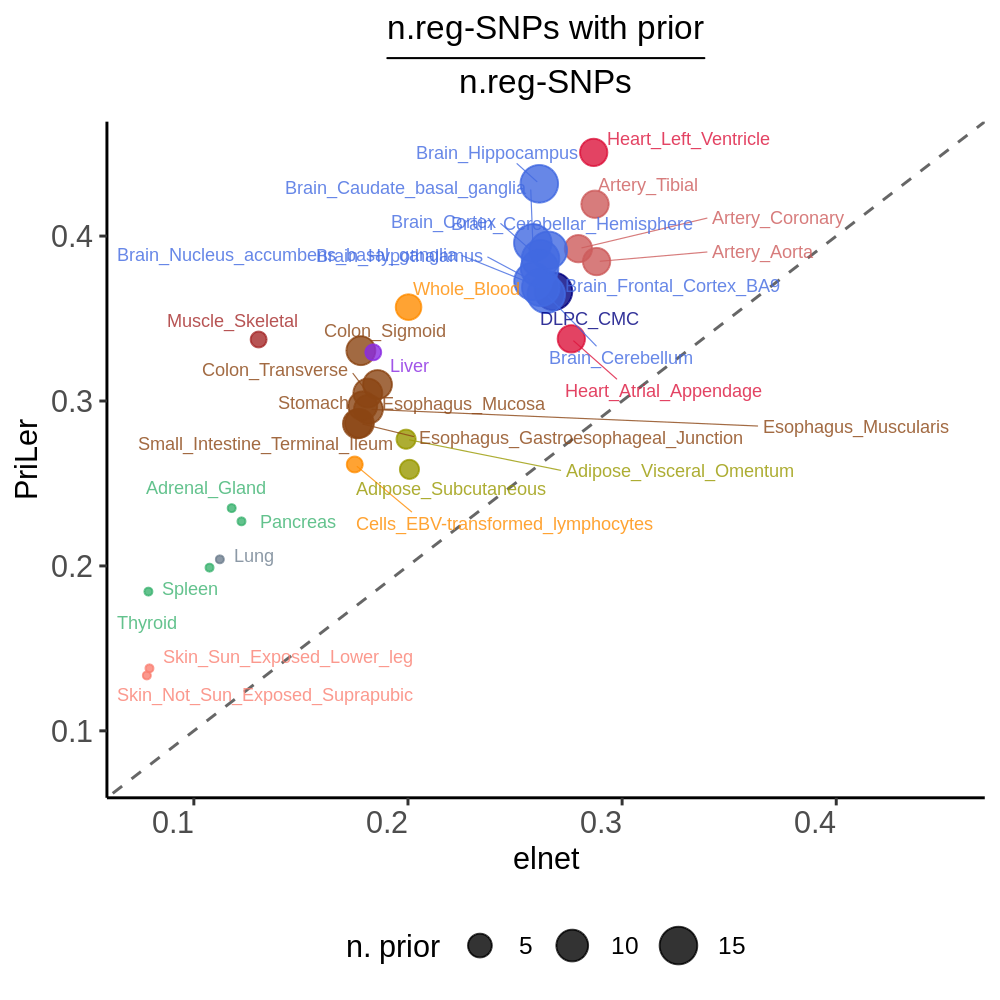

In [8]:
###############################
### plot number of reg-SNPs ###
###############################
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

df_snps$tissue <- factor(df_snps$tissue, levels = n_relGenes$tissues)
df_snps$n_prior <- df_n_prior$n_prior
min_v <- min(c(df_snps$nregSNPS_prior, df_snps$nregSNPS_noprior))
max_v <- max(c(df_snps$nregSNPS_prior, df_snps$nregSNPS_noprior))

pl_nreg <- ggplot(df_snps, aes(x = nregSNPS_noprior, y = nregSNPS_prior, color = tissue, size = n_prior)) + 
  geom_point(alpha = 0.8)+ xlim(min_v, max_v)+ ylim(min_v, max_v)+
  geom_abline(slope = 1, intercept = 0, linetype = 2, alpha = 0.6)+ggtitle('n. reg-SNPs')+
  xlab('elnet')+ ylab('PriLer')+ theme_classic()+
  geom_text_repel(max.overlaps = Inf,label = df_snps$tissue, size = 2.3, alpha = 0.8, segment.size = 0.2, force = 10)+
  theme(plot.title = element_text(hjust = 0.5, size = 12), text = element_text(size = 11),
        axis.text.x=element_text(size = 11, angle = 0, hjust = 1),
        axis.text.y=element_text(size = 11), legend.position = 'bottom')+
  guides(color = FALSE, size = guide_legend(title="n. prior"))+
  scale_color_manual(values = n_relGenes$col)

ggsave(filename = sprintf('%snRegSNPs_PriLerVSelnet_AllTissues.png', outFold), plot = pl_nreg, width = 5, height = 5, dpi = 500)
ggsave(filename = sprintf('%snRegSNPs_PriLerVSelnet_AllTissues.pdf', outFold), plot = pl_nreg, width = 5, height = 5, dpi = 500)

# plot
pl_nreg

min_v <- min(c(df_snps$frac_noprior, df_snps$frac_prior))
max_v <- max(c(df_snps$frac_noprior, df_snps$frac_prior))

pl_frac <- ggplot(df_snps, aes(x = frac_noprior, y = frac_prior, color = tissue, size = n_prior)) + 
  geom_point(alpha = 0.8)+ xlim(min_v, max_v)+ ylim(min_v, max_v)+ggtitle(expression(frac("n.reg-SNPs with prior","n.reg-SNPs")))+
  geom_abline(slope = 1, intercept = 0, linetype = 2, alpha = 0.6)+
  xlab('elnet')+ ylab('PriLer')+ theme_classic()+
  geom_text_repel(max.overlaps = Inf, label = df_snps$tissue, size = 2.3, alpha = 0.8, segment.size = 0.2, force = 10)+
  theme(plot.title = element_text(hjust = 0.5, size = 12), text = element_text(size = 11),
        axis.text.x=element_text(size = 11, angle = 0, hjust = 1),
        axis.text.y=element_text(size = 11), legend.position = 'bottom')+
  guides(color = FALSE, size = guide_legend(title="n. prior"))+
  scale_color_manual(values = n_relGenes$col)

ggsave(filename = sprintf('%sFracRegSNPs_PriLerVSelnet_AllTissues.png', outFold), plot = pl_frac, width = 5, height = 5, dpi = 500)
ggsave(filename = sprintf('%sFracRegSNPs_PriLerVSelnet_AllTissues.pdf', outFold), plot = pl_frac, width = 5, height = 5, dpi = 500)

# plot
pl_frac

df_snps$diff_nregSNPs <- df_snps$nregSNPS_prior - df_snps$nregSNPS_noprior
df_snps$diff_fracprior <- df_snps$frac_prior - df_snps$frac_noprior
paste("correlation n. priors and difference n.reg-SNPs (PriLer - enet):",
      cor(df_snps$n_prior, df_snps$diff_nregSNPs)) # -0.685447
paste("correlation n. priors and difference fraction prior reg-SNPs (PriLer - enet):",
      cor(df_snps$n_prior, df_snps$diff_fracprior)) # 0.256
paste("mean difference reg-SNPs (PriLer - enet):",
      mean(df_snps$diff_nregSNPs)) # -43013.71 +/- 14530.51, sum -1462466
paste("SD difference reg-SNPs (PriLer - enet):",
      sd(df_snps$diff_nregSNPs))
paste("sum difference reg-SNPs (PriLer - enet):",
      sum(df_snps$diff_nregSNPs))
paste("mean difference fraction of reg-SNPs (PriLer - enet):", 
      mean(df_snps$diff_fracprior)) # 0.11 +/- 0.03324765
paste("mean difference fraction of reg-SNPs (PriLer - enet):", 
      sd(df_snps$diff_fracprior)) 

summary_table$n_regSNPs  <- df_snps$nregSNPS_prior
summary_table$fraction_regSNPs_withPrior  <- df_snps$frac_prior



In [9]:
df_snps

tissue,nregSNPS_prior,nregSNPS_noprior,frac_prior,frac_noprior,n_prior,diff_nregSNPs,diff_fracprior
<fct>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
DLPC_CMC,366706,421388,0.3665143,0.26793596,15,-54682,0.09857836
Adipose_Subcutaneous,423635,443664,0.2585433,0.20068565,3,-20029,0.05785767
Adipose_Visceral_Omentum,386744,412900,0.2768343,0.19911601,3,-26156,0.07771828
Adrenal_Gland,377947,410689,0.2350409,0.11766081,1,-32742,0.11738008
Artery_Aorta,402688,448926,0.3845483,0.28808534,7,-46238,0.09646299
Artery_Coronary,343528,384512,0.3923669,0.27958555,7,-40984,0.11278130
Artery_Tibial,364109,422293,0.4193167,0.28735972,7,-58184,0.13195702
Brain_Caudate_basal_ganglia,349538,406266,0.3958740,0.25830613,15,-56728,0.13756785
Brain_Cerebellar_Hemisphere,393519,469718,0.3913483,0.26551676,15,-76199,0.12583156


[1] "correlation percentage improvement (PriLer VS enet) and n.of prior: 0.480846218657277"

[1] "correlation percentage improvement (PriLer VS enet) and n.of samples: -0.281991591265497"


	Exact binomial test

data:  df_tab$n_genes[1] and sum(df_tab$n_genes)
number of successes = 74594, number of trials = 131150, p-value <
2.2e-16
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.5660830 0.5714512
sample estimates:
probability of success 
             0.5687686 


[1] 1.482197e-323

Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


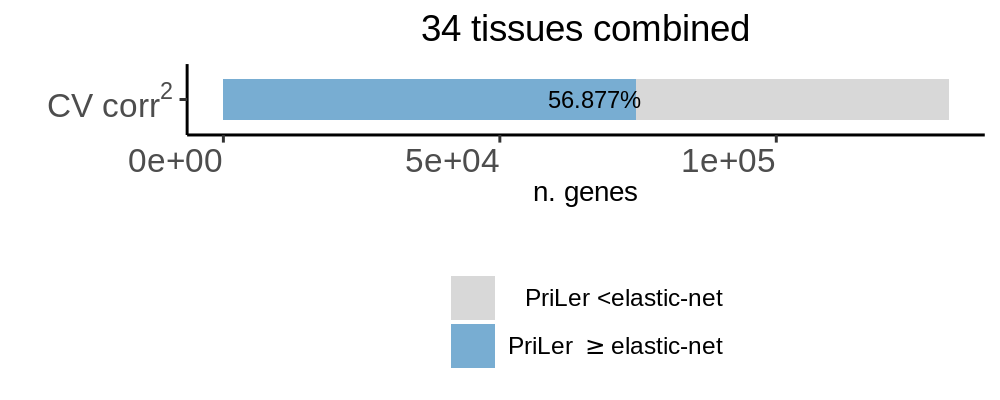

In [10]:
########################
### plot increase R2 ###
########################

options(repr.plot.width = 5, repr.plot.height = 2, repr.plot.res = 200)

df_R2 <- do.call(rbind, df_both)
df_R2$diff <- df_R2$dev_geno_prior - df_R2$dev_geno_noprior
df_R2$ratio <- df_R2$dev_geno_prior/df_R2$dev_geno_noprior
df_R2$diff_test <- df_R2$test_dev_geno_prior - df_R2$test_dev_geno_noprior
df_R2$ratio_test <- df_R2$test_dev_geno_prior/df_R2$test_dev_geno_noprior

# for each tissue, find the number of genes with better performance on test
df_genes_R2 <- data.frame(tissues = c('DLPC_CMC', tissues_model$tissue))
df_genes_R2$n_impr_R2_test <- sapply(df_genes_R2$tissue, function(x) sum(df_R2$diff_test[df_R2$tissue == x] >=0, na.rm = T))
df_genes_R2$tot_genes <- sapply(df_genes_R2$tissue, function(x) sum(df_R2$tissue == x, na.rm = T))
df_genes_R2$perc_impr_R2_test <- df_genes_R2$n_impr_R2_test/df_genes_R2$tot_genes*100

summary_table$nImpr_R2test_vsEnet <- df_genes_R2$n_impr_R2_test
summary_table$percImpr_R2test_vsEnet <- df_genes_R2$perc_impr_R2_test

paste("correlation percentage improvement (PriLer VS enet) and n.of prior:", 
      cor(summary_table$percImpr_R2test_vsEnet, summary_table$n_prior_feat)) # 0.48084
paste("correlation percentage improvement (PriLer VS enet) and n.of samples:", 
      cor(summary_table$percImpr_R2test_vsEnet, summary_table$n_training_samples)) # -0.2819916

                                
df_tab <- data.frame(method = c('PriLer', 'elastic-net'), n_genes = c(sum(df_genes_R2$n_impr_R2_test), sum(df_genes_R2$tot_genes) - sum(df_genes_R2$n_impr_R2_test)),
                     type = c(rep('CV',2)))
df_tab$type <- factor(df_tab$type)
df_tab$add_info <- df_tab$n_genes[1]/sum(df_tab$n_genes)*100
df_tab$add_info <- paste0(round(df_tab$add_info, digits = 3), '%')
df_tab$add_info[2] <- NA
group_name <- c(TeX('CV $corr^2$'))
df_tab$method <- factor(df_tab$method, levels = rev(c('PriLer', 'elastic-net')))
binom.test(x = df_tab$n_genes[1],n = sum(df_tab$n_genes))
binom.test(x = df_tab$n_genes[1],n = sum(df_tab$n_genes))$p.value

pl_bar <- ggplot(df_tab, aes(x = type, y = n_genes, fill = method)) +
  geom_bar(stat="identity", alpha = 0.6, width = 0.7) + ggtitle('34 tissues combined')+
  geom_text(aes(label = add_info), position = position_stack(0.9), color = "black", size = 3)+
  xlab('') +  theme_classic() + ylab(TeX('n. genes')) + theme(legend.position = 'bottom', legend.title = element_blank(), legend.direction  = 'vertical', plot.title = element_text(hjust = 0.5), 
                                                              axis.text = element_text(size = 12), axis.title = element_text(size = 10), 
                                                              axis.text.x = element_text(angle = 0, vjust = 1, hjust = 1))+
  scale_fill_manual(labels = parse(text = (c(TeX(paste0('PriLer $<$', 'elastic-net')), TeX(paste0('PriLer $\\geq$', 'elastic-net'))))), values = rev(c("#1F77B4FF", 'grey')))+
  scale_x_discrete(labels=parse(text = group_name))+ coord_flip()

ggsave(sprintf('%scomparison_methods_increaseAllTissues_PriLer_elnet.png', outFold), pl_bar, width = 5, height = 2, units = "in", dpi=500)
ggsave( sprintf('%scomparison_methods_increaseAllTissues_PriLer_elnet.pdf', outFold), pl_bar, width = 5, height = 2, units = "in", dpi=500)

# plot 
pl_bar
                                

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 34 rows containing missing values (geom_text).”
Warning message:
“Removed 34 rows containing missing values (geom_text).”
Warning message:
“Removed 34 rows containing missing values (geom_text).”


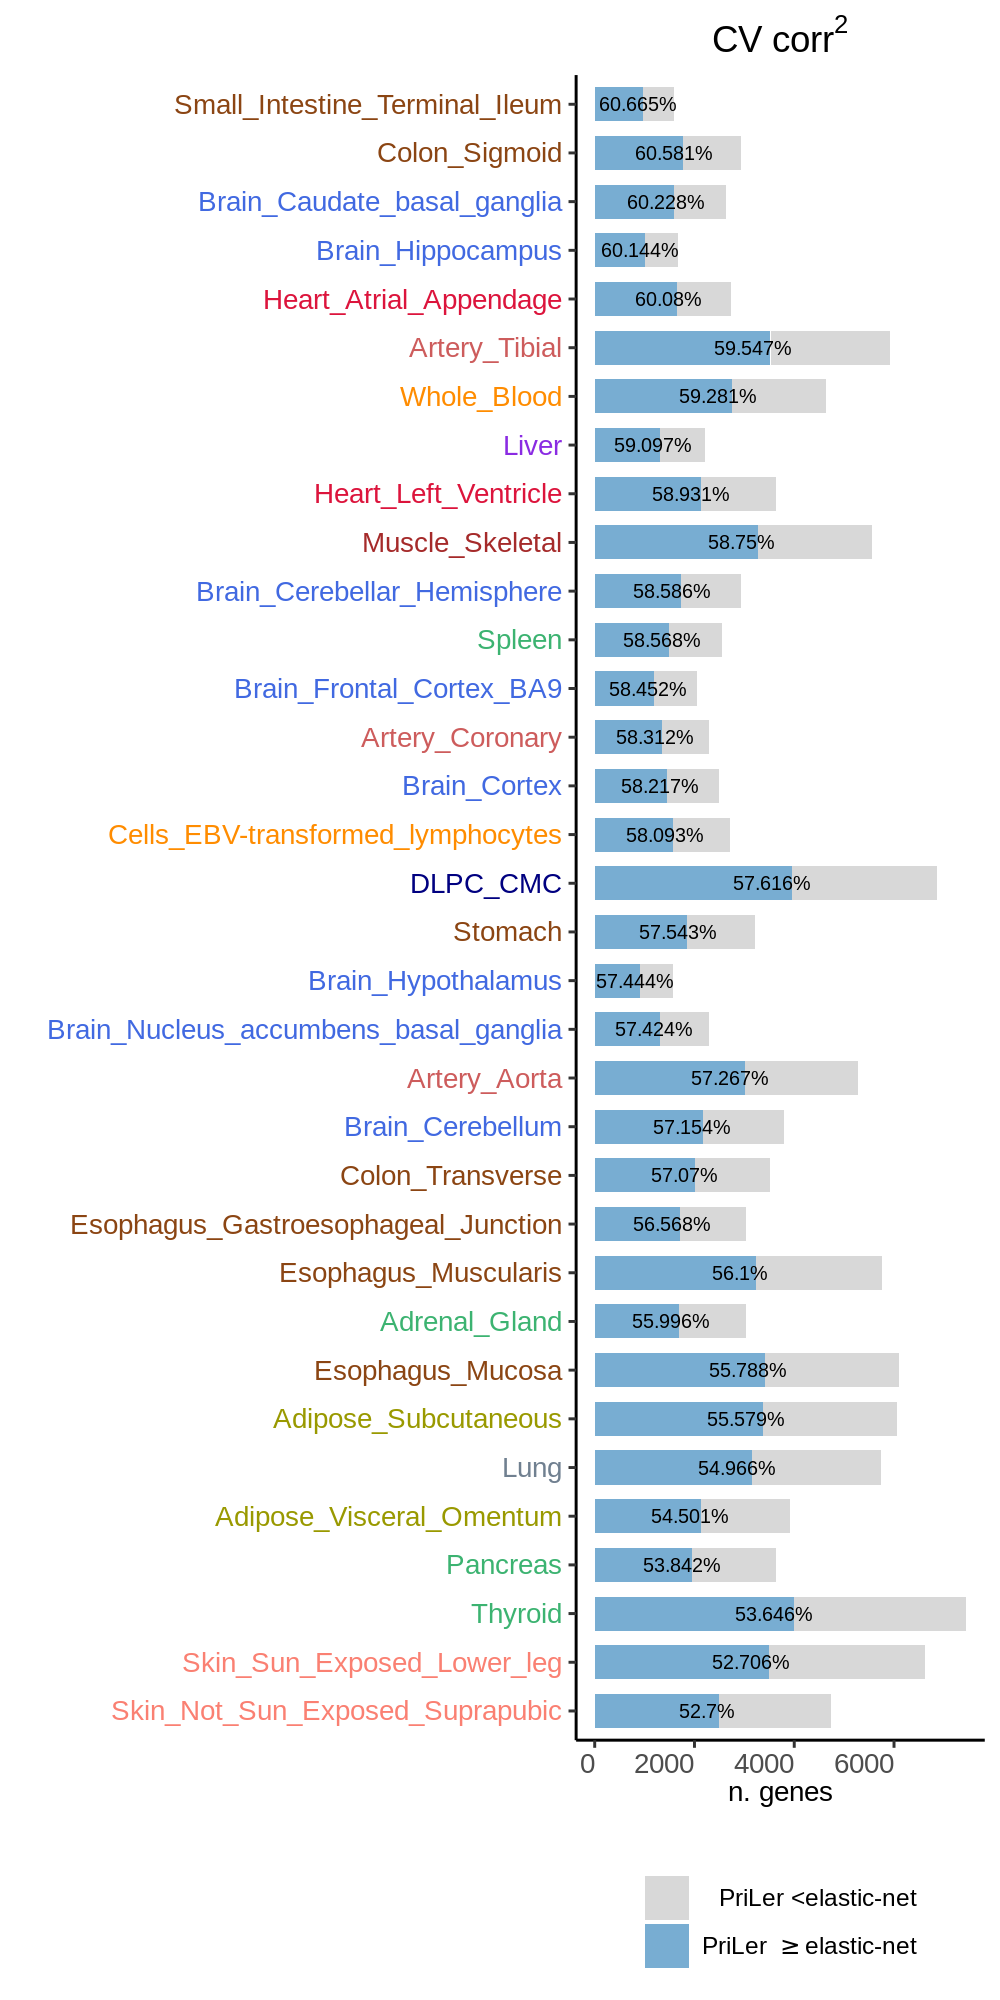

In [11]:
########################
### plot increase R2 ###
########################

options(repr.plot.width = 5, repr.plot.height = 10, repr.plot.res = 200)

df_tab <- data.frame(method = rep(c('PriLer', 'elastic-net'), nrow(df_genes_R2)), 
                     n_genes = unlist(lapply(df_genes_R2$tissue, function(x) c(df_genes_R2$n_impr_R2_test[df_genes_R2$tissue == x], df_genes_R2$tot_genes[df_genes_R2$tissue == x] - df_genes_R2$n_impr_R2_test[df_genes_R2$tissue == x]))), 
                     add_info = NA, tissue = unlist(lapply(df_genes_R2$tissue, function(x) rep(x, 2))))

df_tab$add_info[df_tab$method == 'PriLer'] <- df_genes_R2$n_impr_R2_test/df_genes_R2$tot_genes*100
df_tab$add_info[df_tab$method == 'PriLer'] <- paste0(round(df_tab$add_info[df_tab$method == 'PriLer'], digits = 3), '%')
name_title <- c(TeX('CV $corr^2$'))
df_tab$method <- factor(df_tab$method, levels = rev(c('PriLer', 'elastic-net')))
ord_t <- order(df_genes_R2$n_impr_R2_test/df_genes_R2$tot_genes)
df_tab$tissue <- factor(df_tab$tissue, levels =  c('DLPC_CMC', tissues_model$tissue)[ord_t])


pl_bar <- ggplot(df_tab, aes(x = tissue, y = n_genes, fill = method)) +
  geom_bar(stat="identity", alpha = 0.6, width = 0.7) + ggtitle(name_title)+
  geom_text(aes(label = add_info), position = position_stack(0.9), color = "black", size = 2.5)+
  xlab('') +  theme_classic() + ylab(TeX('n. genes')) + theme(legend.position = 'bottom', legend.title = element_blank(), legend.direction  = 'vertical', plot.title = element_text(hjust = 0.5), 
                                                              axis.text = element_text(size = 10), axis.title = element_text(size = 10), 
                                                              axis.text.y = element_text(angle = 0, color = n_relGenes$col[ord_t]), 
                                                              axis.text.x = element_text(angle = 0, vjust = 1, hjust = 1))+
  scale_fill_manual(labels = parse(text = (c(TeX(paste0('PriLer $<$', 'elastic-net')), TeX(paste0('PriLer $\\geq$', 'elastic-net'))))), values = rev(c("#1F77B4FF", 'grey')))+
  coord_flip()

ggsave(sprintf('%scomparison_methods_increase_PriLer_elnet.png', outFold), pl_bar, width = 5, height = 10, units = "in", dpi=500)
ggsave( sprintf('%scomparison_methods_increase_PriLer_elnet.pdf', outFold), pl_bar, width = 5, height = 10, units = "in", dpi=500)

# plot
pl_bar                                                           

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


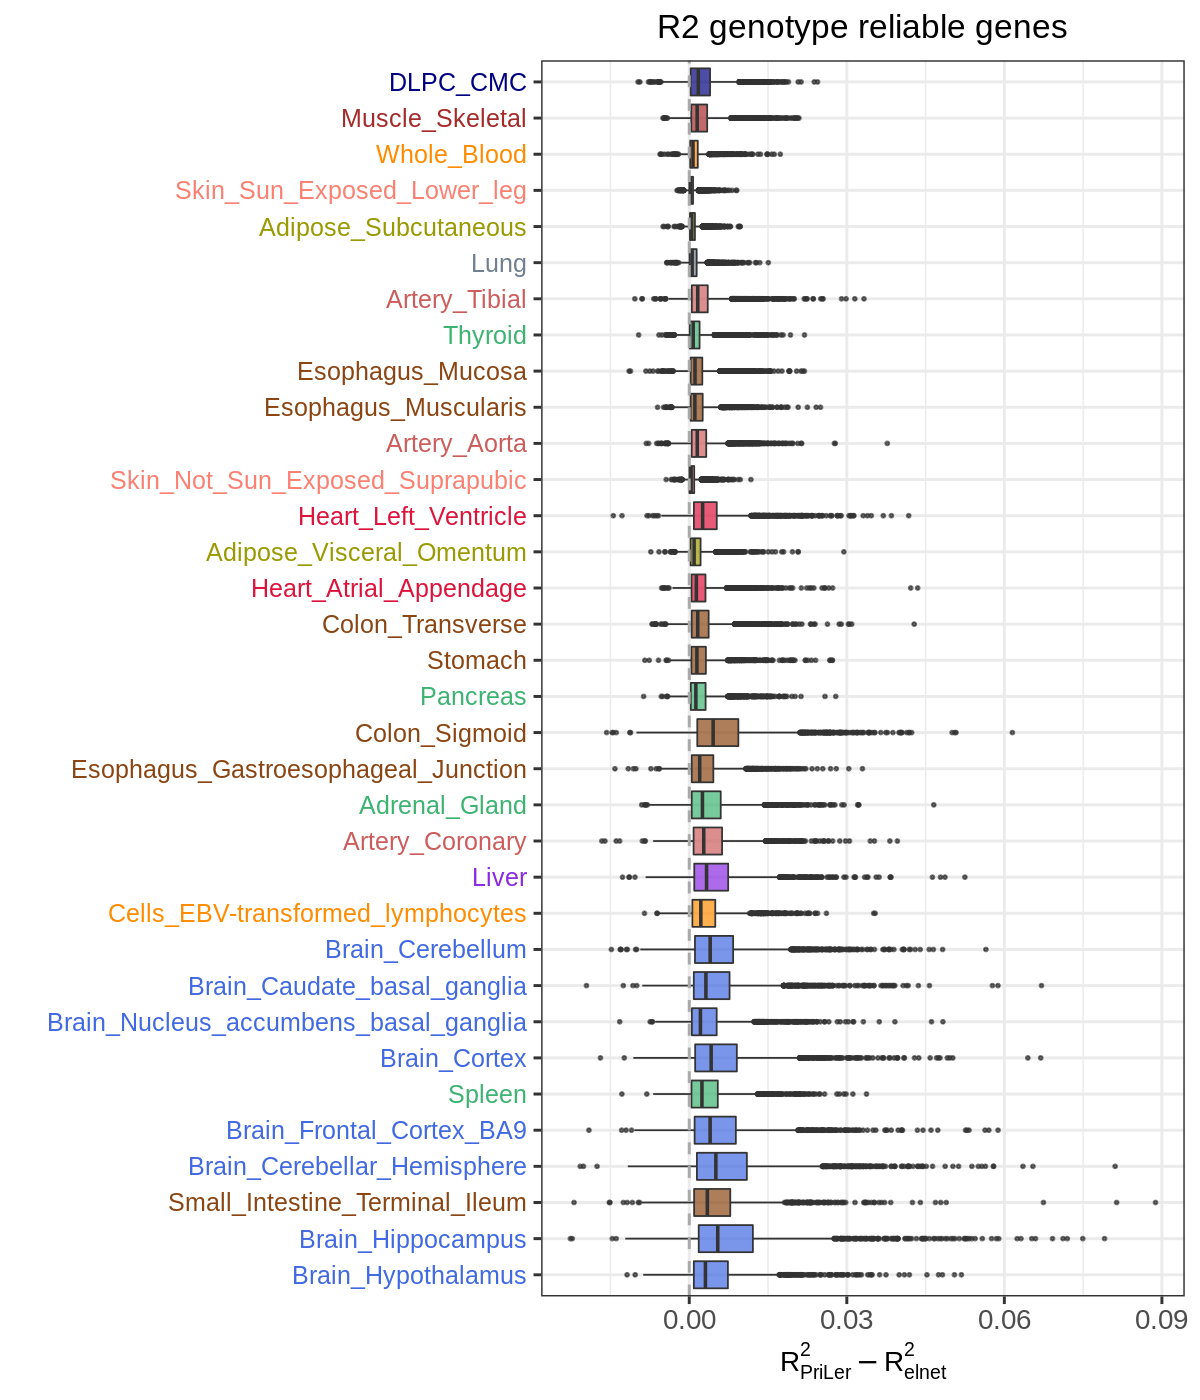

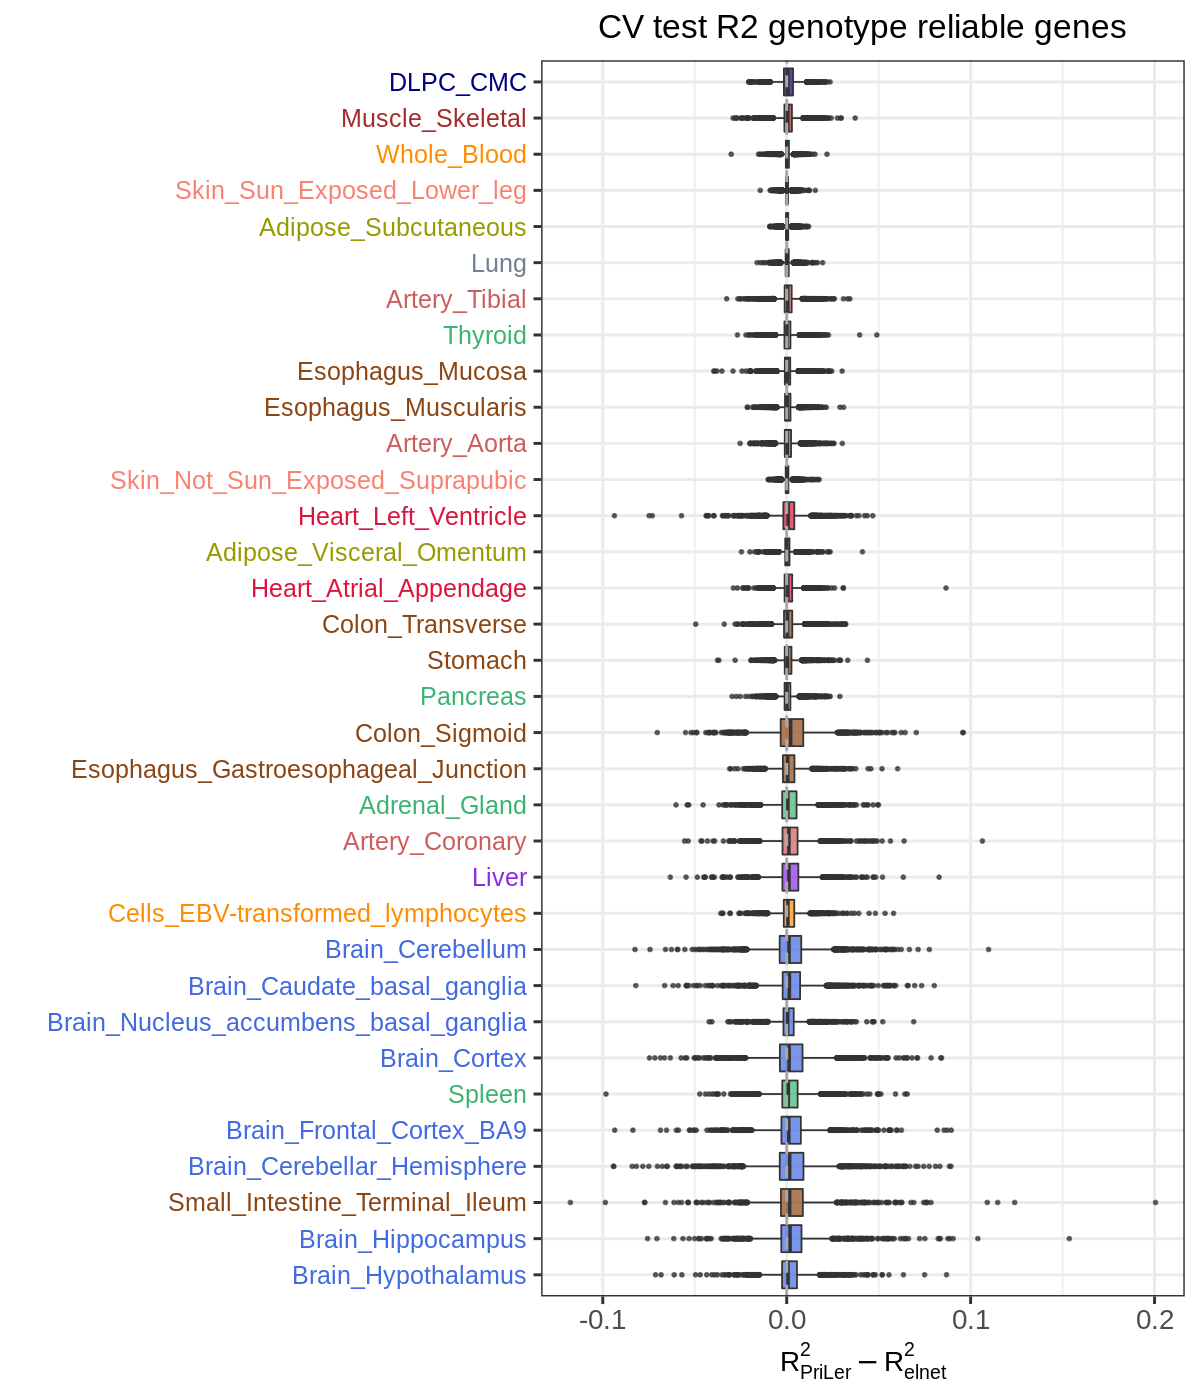

In [12]:
############################
### plot distribution R2 ###
############################

options(repr.plot.width = 6, repr.plot.height = 7, repr.plot.res = 200)

order_t <- order(summary_table$n_training_samples)
df_R2$tissue <- factor(df_R2$tissue, levels = n_relGenes$tissues[order_t])

# difference 
pl_box_R2diff <- ggplot(df_R2, aes(x = tissue, y=diff, fill = tissue)) + 
  geom_boxplot(outlier.size = 0.3, alpha = 0.7, size = 0.3)+ ylab(expression(R[PriLer]^2 - R[elnet]^2))+ ggtitle('R2 genotype reliable genes')+
  xlab('')+ theme_bw()+ scale_fill_manual(values = n_relGenes$col[order_t])+
  # scale_y_continuous(trans=weird)+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), text = element_text(size = 10),
        axis.text.y=element_text(size = 9, angle = 0, hjust = 1, colour = n_relGenes$col[order_t]),
        axis.text.x=element_text(size = 10), legend.position = 'none')+coord_flip()

ggsave(filename = sprintf('%sR2geno_diff_allTissues.png', outFold), plot = pl_box_R2diff, width = 6, height = 7, dpi=500)
ggsave(filename = sprintf('%sR2geno_diff_allTissues.pdf', outFold), plot = pl_box_R2diff, width = 6, height = 7, dpi=500)

pl_box_R2diff

# difference (test)
pl_box_R2diff <- ggplot(df_R2, aes(x = tissue, y=diff_test, fill = tissue)) + 
  geom_boxplot(outlier.size = 0.3, alpha = 0.7, size = 0.3)+ ylab(expression(R[PriLer]^2 - R[elnet]^2))+ ggtitle('CV test R2 genotype reliable genes')+
  xlab('')+ theme_bw()+ scale_fill_manual(values = n_relGenes$col[order_t])+
  geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
  # scale_y_continuous(trans=weird)+
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), text = element_text(size = 10),
        axis.text.y=element_text(size = 9, angle = 0, hjust = 1, colour = n_relGenes$col[order_t]),
        axis.text.x=element_text(size = 10), legend.position = 'none')+coord_flip()

ggsave(filename = sprintf('%sR2geno_diffTest_allTissues.png', outFold), plot = pl_box_R2diff, width = 6, height = 7, dpi=500)
ggsave(filename = sprintf('%sR2geno_diffTest_allTissues.pdf', outFold), plot = pl_box_R2diff, width = 6, height = 7, dpi=500)

pl_box_R2diff

In [73]:
# test for each tissue
df_test_R2 <- data.frame(tissue = n_relGenes$tissue, 
                         wilcoxon_testgeno_pval = sapply(n_relGenes$tissue, function(x) wilcox.test(df_R2$test_dev_geno_prior[df_R2$tissue == x & !is.na(df_R2$diff_test)], 
                                                                                                    df_R2$test_dev_geno_noprior[df_R2$tissue == x  & !is.na(df_R2$diff_test)], paired = T, alternative = 'greater')$p.value))
df_test_R2$wilcoxon_geno_pval <- sapply(n_relGenes$tissue, function(x) wilcox.test(df_R2$dev_geno_prior[df_R2$tissue == x], df_R2$dev_geno_noprior[df_R2$tissue == x], paired = T, alternative = 'greater')$p.value)
df_test_R2$binom_testgeno_pval <- sapply(n_relGenes$tissue, function(x) binom.test(x = length(which(df_R2$diff_test[df_R2$tissue == x]>0)),n = length(df_R2$diff_test[df_R2$tissue == x]))$p.value)
df_test_R2$binom_geno_pval <- sapply(n_relGenes$tissue, function(x) binom.test(x = length(which(df_R2$diff[df_R2$tissue == x]>0)),n = length(df_R2$diff[df_R2$tissue == x]))$p.value)
df_test_R2$binom_testgeno_perc <- sapply(n_relGenes$tissue, function(x) sum(df_R2$diff_test[df_R2$tissue == x]>0, na.rm = T)/length(df_R2$diff_test[df_R2$tissue == x]))
df_test_R2$binom_geno_perc <- sapply(n_relGenes$tissue, function(x) sum(df_R2$diff[df_R2$tissue == x]>0, na.rm = T)/length(df_R2$diff[df_R2$tissue == x]))

rownames(df_test_R2) <- NULL
df_test_R2
                                     
write.table(file = sprintf('%scompare_PriLer_enet_R2impr.txt', outFold), df_test_R2, quote = F, col.names = T, row.names = F, sep = '\t')


tissue,wilcoxon_testgeno_pval,wilcoxon_geno_pval,binom_testgeno_pval,binom_geno_pval,binom_testgeno_perc,binom_geno_perc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DLPC_CMC,2.782435e-69,0.000000e+00,1.583582e-36,4.940656e-324,0.5761599,0.8333820
Adipose_Subcutaneous,2.306082e-36,0.000000e+00,3.913063e-18,0.000000e+00,0.5557940,0.8854407
Adipose_Visceral_Omentum,7.658007e-20,0.000000e+00,1.943386e-08,4.940656e-324,0.5450128,0.8833760
Adrenal_Gland,1.217245e-21,0.000000e+00,4.477645e-11,0.000000e+00,0.5599604,0.8592666
Artery_Aorta,1.669272e-46,0.000000e+00,4.412902e-26,4.940656e-324,0.5726739,0.8982376
Artery_Coronary,1.130859e-26,0.000000e+00,1.639548e-15,0.000000e+00,0.5831158,0.8929504
Artery_Tibial,4.575387e-64,0.000000e+00,4.736569e-49,4.940656e-324,0.5954714,0.8984454
Brain_Caudate_basal_ganglia,4.300203e-39,0.000000e+00,7.185060e-26,0.000000e+00,0.6022770,0.8876660
Brain_Cerebellar_Hemisphere,2.074147e-27,0.000000e+00,1.204662e-20,4.940656e-324,0.5858552,0.8949337


In [59]:
# save summary table
write.table(file = sprintf('%sPriLer_summary_tissueSpecific.txt', outFold), x = summary_table, quote = F, col.names = T, row.names = F, sep = '\t')
paste('correlation fraction of improved genes in PriLer and n.of prior:', 
      cor(summary_table$percImpr_R2test_vsEnet, summary_table$n_prior_feat))
                                     
paste('correlation fraction of improved genes in PriLer and n.of trainign samples:',
    cor(summary_table$percImpr_R2test_vsEnet, summary_table$n_training_samples))

[1] "correlation fraction of improved genes in PriLer and n.of prior: 0.480846218657277"

[1] "correlation fraction of improved genes in PriLer and n.of trainign samples: -0.281991591265497"

In [73]:
############################################
### robustness results, compared to enet ###
############################################

setwd('/psycl/g/mpsziller/lucia/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2/Whole_Blood/200kb/')
nrep <- 10

# load baseline results
load('noGWAS/resPrior_regCoeffSnps_allchr.RData')
load('noGWAS/resNoPrior_regCoeffSnps_allchr.RData')
nSNPs <- sum(sapply(beta_snps_p, nrow))

regSNPs <- data.frame(PriLer_n = rep(0, nSNPs), elnet_n = rep(0, nSNPs), PriLer = rep(F, nSNPs), elnet = rep(F, nSNPs))
regSNPs$PriLer_n <- unlist(lapply(beta_snps_p, function(x) rowSums(x != 0)))
regSNPs$elnet_n <- unlist(lapply(beta_snps_nop, function(x) rowSums(x != 0)))
regSNPs$PriLer[unlist(lapply(beta_snps_p, function(x) rowSums(x != 0))) > 0] <- T
regSNPs$elnet[unlist(lapply(beta_snps_nop, function(x) rowSums(x != 0))) > 0] <- T

regSNPs_rep <- list()
for(i in 1:nrep){
  
  print(i)
  
  load(sprintf('robustness_analysis/rep%i/noGWAS/resPrior_regCoeffSnps_allchr.RData', i))
  load(sprintf('robustness_analysis/rep%i/noGWAS/resNoPrior_regCoeffSnps_allchr.RData', i))
  
  regSNPs_rep[[i]] <-  data.frame(PriLer_n = rep(0, nSNPs), elnet_n = rep(0, nSNPs), PriLer = rep(F, nSNPs), elnet = rep(F, nSNPs))
  regSNPs_rep[[i]]$PriLer_n <- unlist(lapply(beta_snps_p, function(x) rowSums(x != 0)))
  regSNPs_rep[[i]]$elnet_n <- unlist(lapply(beta_snps_nop, function(x) rowSums(x != 0)))
  regSNPs_rep[[i]]$PriLer[unlist(lapply(beta_snps_p, function(x) rowSums(x != 0))) > 0] <- T
  regSNPs_rep[[i]]$elnet[unlist(lapply(beta_snps_nop, function(x) rowSums(x != 0))) > 0] <- T
  
}


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


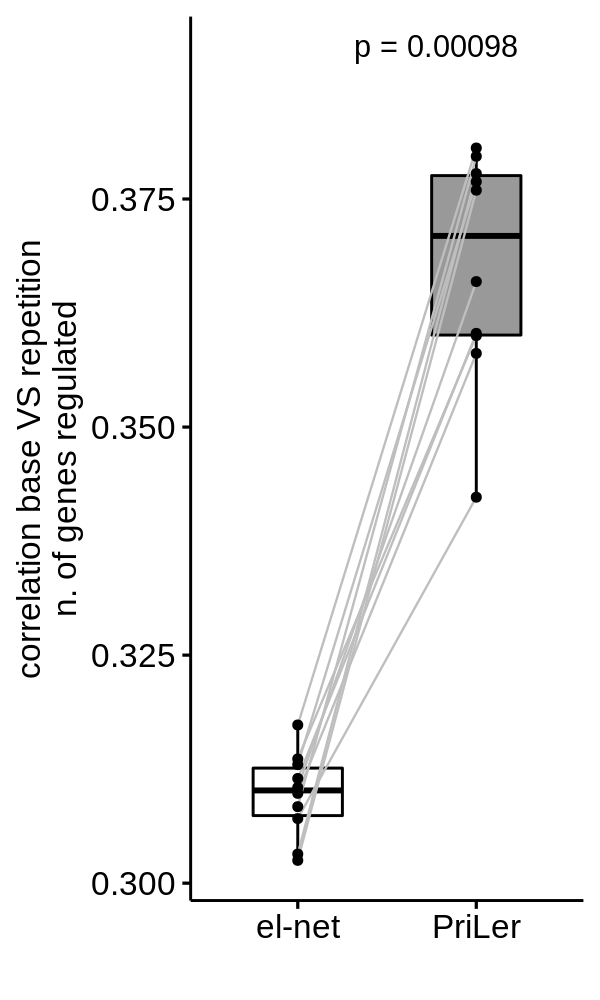

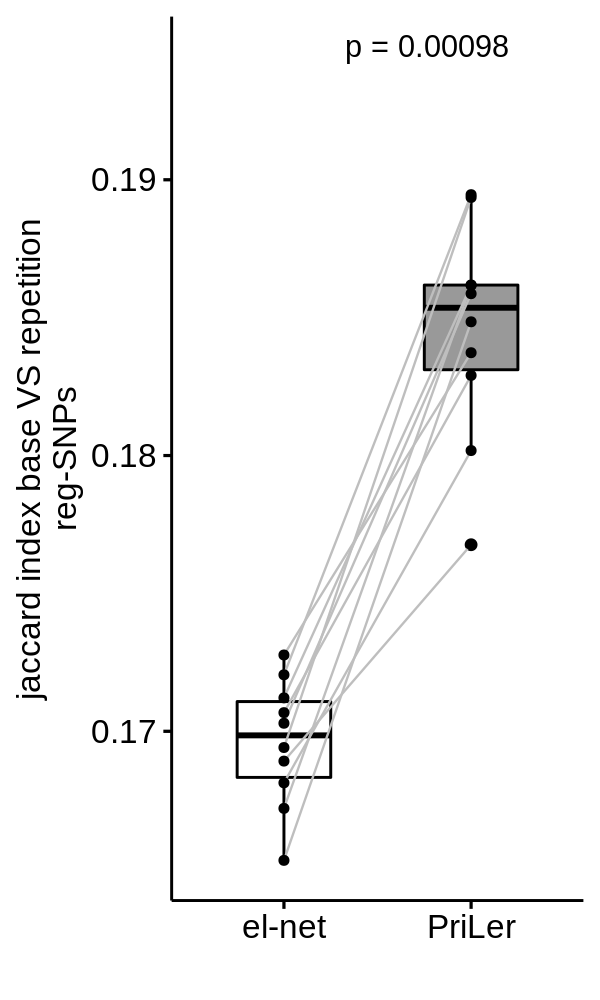

In [81]:
### compare with baseline ###

options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 200)

df_base <- data.frame(cor = rep(NA, nrep*2), jaccard = rep(NA, nrep*2), type = c(rep('PriLer', nrep),rep('el-net', nrep)))
df_base$cor <- c(sapply(regSNPs_rep, function(x) cor(x$PriLer_n, regSNPs$PriLer_n)), sapply(regSNPs_rep, function(x) cor(x$elnet_n, regSNPs$elnet_n)))
df_base$jaccard <- c(sapply(regSNPs_rep, function(x) jaccard(x$PriLer, regSNPs$PriLer)), sapply(regSNPs_rep, function(x) jaccard(x$elnet, regSNPs$elnet)))
df_base$type <- factor(df_base$type, levels = c('el-net', 'PriLer'))

pl <- ggpaired(df_base, x = "type", y = "cor", fill = "type", alpha = 0.7, palette = c('white', 'grey60'),
               line.color = "gray", line.size = 0.4, add.params = list(fill = "white"))+ 
  stat_compare_means(method.args = list(alternative = "less"), paired = TRUE, label = "p.format", label.y = max(df_base$cor) + 0.01, label.x.npc = 'center')
pl <- ggpar(pl, legend = "none", xlab = '', ylab = 'correlation base VS repetition\nn. of genes regulated')
# plot 
pl
ggsave(pl, filename = paste0(outFold, 'robustness_corr_compare_base.png'), width = 3, height = 5, dpi = 320, device = 'png')
ggsave(pl, filename = paste0(outFold, 'robustness_corr_compare_base.pdf'), width = 3, height = 5,  device = 'pdf')

                                                                                                
pl <- ggpaired(df_base, x = "type", y = "jaccard", fill = "type", alpha = 0.7, palette = c('white', 'grey60'),
               line.color = "gray", line.size = 0.4, add.params = list(fill = "white"))+ 
  stat_compare_means(method.args = list(alternative = "less"), paired = TRUE, label = "p.format", label.y = max(df_base$jaccard) + 0.005, label.x.npc = 'center')
pl <- ggpar(pl, legend = "none", xlab = '', ylab = 'jaccard index base VS repetition\nreg-SNPs')

# plot 
pl
ggsave(pl, filename = paste0(outFold, 'robustness_jaccard_compare_base.png'), width = 3, height = 5, dpi = 320, device = 'png')
ggsave(pl, filename = paste0(outFold, 'robustness_jaccard_compare_base.pdf'), width = 3, height = 5,  device = 'pdf')


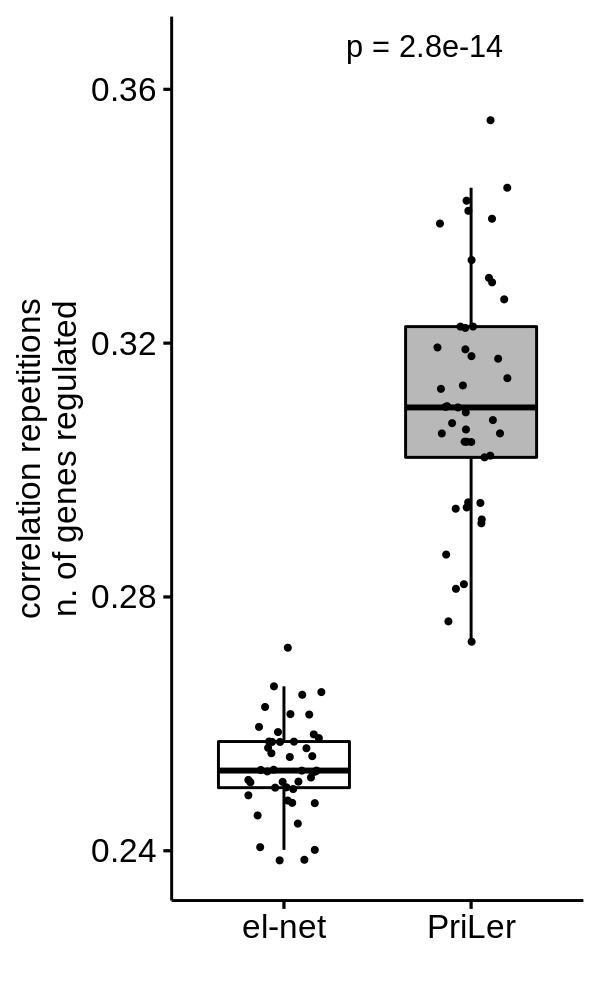

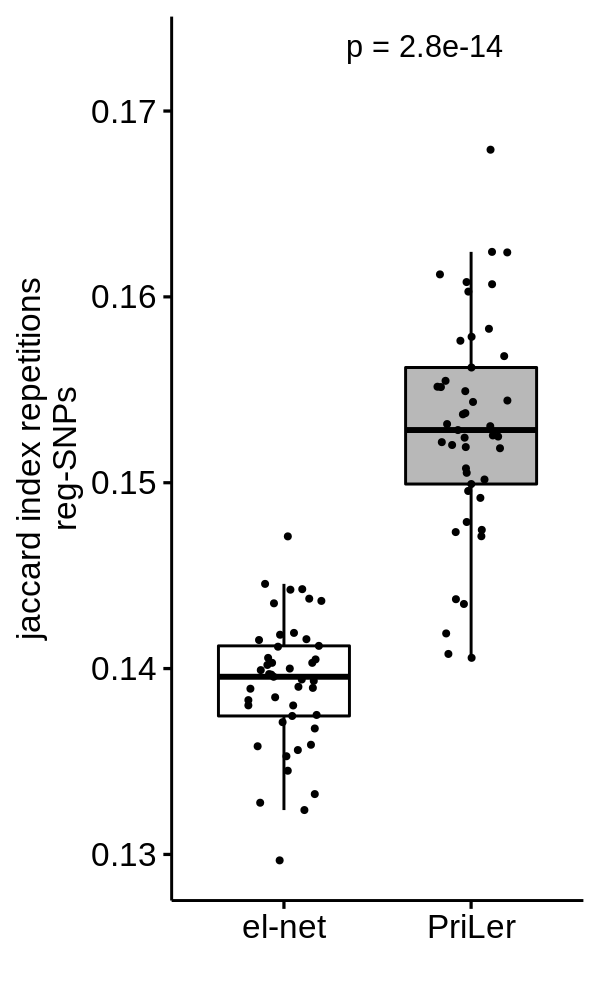

In [87]:
### compare between repetitions ###
options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 200)

mat_cor <- mat_jacc <- matrix(NA, nrow = nrep, ncol = nrep)
for(i in 1:nrep){
  #print(i)
  mat_cor[i,] <- sapply(regSNPs_rep, function(x) cor(x$PriLer_n, regSNPs_rep[[i]]$PriLer_n))
  mat_jacc[i,] <- sapply(regSNPs_rep, function(x) jaccard(x$PriLer, regSNPs_rep[[i]]$PriLer))
}

df_comp <- data.frame(cor = mat_cor[lower.tri(mat_cor)], jaccard = mat_jacc[lower.tri(mat_jacc)], type = rep('PriLer', sum(lower.tri(mat_jacc))))

mat_cor <- mat_jacc <- matrix(NA, nrow = nrep, ncol = nrep)
for(i in 1:nrep){
  #print(i)
  mat_cor[i,] <- sapply(regSNPs_rep, function(x) cor(x$elnet_n, regSNPs_rep[[i]]$elnet_n))
  mat_jacc[i,] <- sapply(regSNPs_rep, function(x) jaccard(x$elnet, regSNPs_rep[[i]]$elnet))
}

df_comp <- rbind(df_comp, data.frame(cor = mat_cor[lower.tri(mat_cor)], jaccard = mat_jacc[lower.tri(mat_jacc)], type = rep('el-net', sum(lower.tri(mat_jacc)))))
df_comp$type <- factor(df_comp$type, levels = c( 'el-net','PriLer'))

pl <- ggboxplot(df_comp, x = "type", y = "cor", fill = "type", alpha = 0.7, palette = c('white', 'grey60'),
                add = "jitter", add.params = list(size = 0.7, jitter = 0.2),  
                outlier.shape = NA)+ 
  stat_compare_means(method.args = list(alternative = "less"), paired = TRUE, label = "p.format", label.y = max(df_comp$cor) + 0.01, label.x.npc = 'center')
pl <- ggpar(pl, legend = "none", xlab = '', ylab = 'correlation repetitions\nn. of genes regulated')
#plot
pl
ggsave(pl, filename = paste0(outFold, 'robustness_corr_compare_rep.png'), width = 3, height = 5, dpi = 320, device = 'png')
ggsave(pl, filename = paste0(outFold, 'robustness_corr_compare_rep.pdf'), width = 3, height = 5,  device = 'pdf')

pl <- ggboxplot(df_comp, x = "type", y = "jaccard", fill = "type", alpha = 0.7, palette = c('white', 'grey60'),
                add = "jitter",  add.params = list(size = 0.7, jitter = 0.2),  
                outlier.shape = NA)+ 
  stat_compare_means(method.args = list(alternative = "less"), paired = TRUE, label = "p.format", label.y = max(df_comp$jaccard) + 0.005, label.x.npc = 'center')
pl <- ggpar(pl, legend = "none", xlab = '', ylab = 'jaccard index repetitions\nreg-SNPs')
#plot
pl
ggsave(pl, filename = paste0(outFold, 'robustness_jaccard_compare_rep.png'), width = 3, height = 5, dpi = 320, device = 'png')
ggsave(pl, filename = paste0(outFold, 'robustness_jaccard_compare_rep.png'), width = 3, height = 5,  device = 'pdf')

# save df
write.table(df_base, file = paste0(outFold, 'robustness_compare_base_repetitions.txt'), col.names = T, row.names = F, sep = '\t', quote = F)
write.table(df_comp, file = paste0(outFold, 'robustness_compare_repetitions.txt'), col.names = T, row.names = F, sep = '\t', quote = F)


                      